In [1]:
!pip3 install wget
import wget
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2 as cv
import numpy as np
import requests
import json
from matplotlib import pyplot as plt
%matplotlib inline

  Running setup.py bdist_wheel for wget ... - done
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
# source: https://stackoverflow.com/posts/49208362/revisions
# A helper function converting opencv images to squres
def get_square(image,square_size):

  height,width,x=image.shape
  if(height>width):
    differ=height
  else:
    differ=width
  differ+=4

  mask = np.zeros((differ,differ,x), dtype="uint8")   
  x_pos=int((differ-width)/2)
  y_pos=int((differ-height)/2)
  mask[y_pos:y_pos+height,x_pos:x_pos+width,:]=image[0:height,0:width,:]
  mask=cv.resize(mask,(square_size,square_size),interpolation=cv.INTER_AREA)

  return mask 
  
# A helper function converting opencv images to certain dimensions
def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
  # initialize the dimensions of the image to be resized and
  # grab the image size
  dim = None
  (h, w) = image.shape[:2]

  # if both the width and height are None, then return the
  # original image
  if width is None and height is None:
      return image

  # check to see if the width is None
  if width is None:
      # calculate the ratio of the height and construct the
      # dimensions
      r = height / float(h)
      dim = (int(w * r), height)

  # otherwise, the height is None
  else:
      # calculate the ratio of the width and construct the
      # dimensions
      r = width / float(w)
      dim = (width, int(h * r))

  # resize the image
  resized = cv.resize(image, dim, interpolation = inter)

  # return the resized image
  return resized

In [0]:
# The database we'll be working with contains images of skin conditions, a segmentation images,
# and metadata about diagnosees, patient information etc.
# ISIC API - we'll get our data through http
api_root = "https://isic-archive.com/api/v1"
api_image = api_root + "/image?limit={0}&sort=name&sortdir=1&detail=true"
api_image_download = api_root + "/image/{0}/download?contentDisposition=inline" #original resolution
api_image_thumbnail = api_root + "/image/{0}/thumbnail?width=256&height=256"
api_segmentation = api_root + "/segmentation?limit=50&sort=created&sortdir=-1&imageId={0}"
api_segmentation_thumbnail = api_root + "/segmentation/{0}/thumbnail?&contentDisposition=inline&width=256"
api_segmentation_mask = api_root + "/segmentation/{0}/mask?contentDisposition=inline"

In [0]:
#empty folders if they are created already
!rm -rf image_thumbnails/*
!rm -rf segmentation_thumbnails/*
!rm -rf segmentation_masks/*

In [0]:
#create folders for downloaded data
!mkdir -p image_thumbnails/benign
!mkdir -p image_thumbnails/malignant
!mkdir -p segmentation_thumbnails
!mkdir -p segmentation_masks

In [0]:
# Download n images
image_count = 50

response = requests.get(api_image.format(image_count))
json_images = json.loads(response.text)

images = []

for json_image in json_images:
  metadata = json_image['meta']['clinical']

  #skip unknowns and intermediates
  if metadata['benign_malignant'] not in ['benign','malignant']:
    continue

  image_thumbnail_filename = wget.download(api_image_thumbnail.format(json_image['_id']), \
                                           out=f"image_thumbnails/{metadata['benign_malignant']}/"+json_image['_id']+".jpg")
  BGR_image_thumbnail = cv.imread(image_thumbnail_filename)
  image_thumbnail = cv.cvtColor(BGR_image_thumbnail, cv.COLOR_BGR2RGB)
  
  response = requests.get(api_segmentation.format(json_image['_id']))
  json_segmentations = json.loads(response.text)
  
  segmentation_thumbnail_filename = wget.download(api_segmentation_thumbnail.format(json_segmentations[0]['_id']))
  !mv $segmentation_thumbnail_filename "segmentation_thumbnails/"$segmentation_thumbnail_filename
  segmentation_thumbnail_filename = "segmentation_thumbnails/" + segmentation_thumbnail_filename
  BGR_segmentation_thumbnail = cv.imread(segmentation_thumbnail_filename)
  segmentation_thumbnail = cv.cvtColor(BGR_segmentation_thumbnail, cv.COLOR_BGR2RGB)
  
  segmentation_mask_filename = wget.download(api_segmentation_mask.format(json_segmentations[0]['_id']))
  !mv $segmentation_mask_filename "segmentation_masks/"$segmentation_mask_filename
  segmentation_mask_filename = "segmentation_masks/" + segmentation_mask_filename
  BGR_segmentation_mask = cv.imread(segmentation_mask_filename)
  segmentation_mask = cv.cvtColor(BGR_segmentation_mask, cv.COLOR_BGR2RGB)
  segmentation_mask = image_resize(segmentation_mask, width = 256)
  
  images.append([image_thumbnail, segmentation_thumbnail, segmentation_mask, metadata])

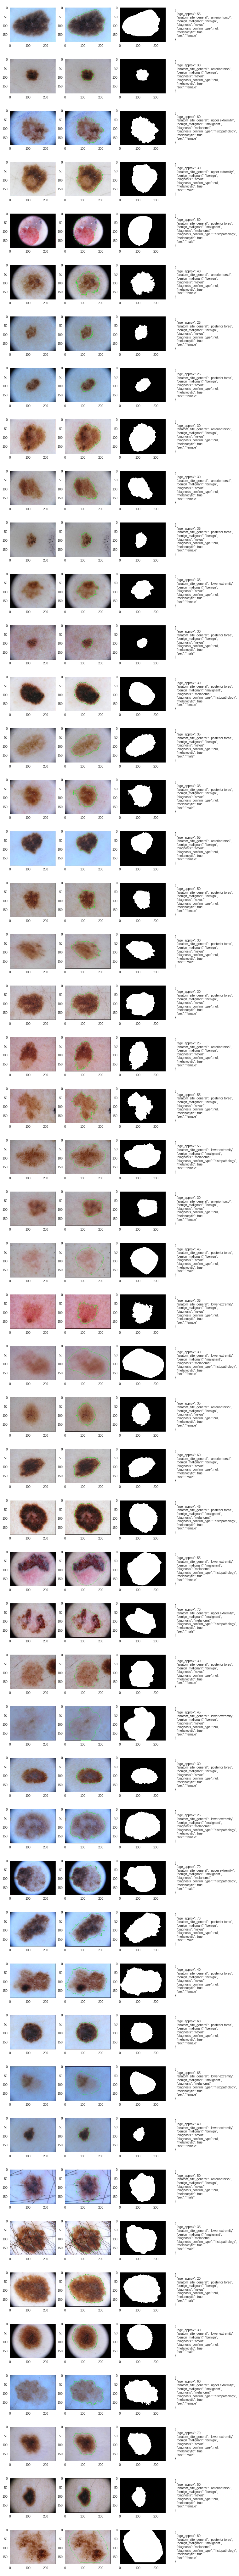

In [7]:
# Let's see the data we were talking about
columns = 4
plt.rcParams["axes.grid"] = False
images_plot = plt.figure(figsize=(12, 3*image_count))
for i in range(1, columns*image_count+1, columns):
  images_plot.add_subplot(image_count, columns, i)
  plt.imshow(images[i//columns][0])
  images_plot.add_subplot(image_count, columns, i+1)
  plt.imshow(images[i//columns][1])
  images_plot.add_subplot(image_count, columns, i+2)
  plt.imshow(images[i//columns][2])
  ax = images_plot.add_subplot(image_count, columns, i+3)
  ax.axis("off")
  ax.text(0, 0.5, str(json.dumps(images[i//columns][3], indent=2)), fontsize=10, ha='left', va='center')

In [8]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [9]:
# rescale pictures and read them from directory
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory('image_thumbnails',target_size=(64, 64),batch_size=10,class_mode='binary')
#segmentation_mask = test_datagen.flow_from_directory('segmentation_masks',target_size=(64, 64),batch_size=10,class_mode='binary')
#segmentation_thumbnails = test_datagen.flow_from_directory('segmentation_thumbnails',target_size=(64, 64),batch_size=10,class_mode='binary')

Found 50 images belonging to 2 classes.


In [0]:
import pandas as pd
import copy

In [11]:
#create DataFrame from metadata list
metadata = copy.deepcopy(np.array(images, copy=True))[:,3]
age_approx=[item["age_approx"] for item in metadata]
anatom_site_general=[item["anatom_site_general"] for item in metadata]
melanocytic=[item["melanocytic"] for item in metadata]
sex=[item["sex"] for item in metadata]
df_metadata = pd.DataFrame(data=[age_approx,anatom_site_general,melanocytic,sex],index=["age_approx","anatom_site_general","melanocytic","sex"])
df_metadata = df_metadata.T
df_metadata

age_approx anatom_site_general melanocytic     sex
0          55      anterior torso        True  female
1          30      anterior torso        True  female
2          60     upper extremity        True  female
3          30     upper extremity        True    male
4          80     posterior torso        True    male
5          40      anterior torso        True  female
6          25     posterior torso        True  female
7          25     posterior torso        True  female
8          30      anterior torso        True  female
9          30      anterior torso        True  female
10         35     posterior torso        True  female
11         35     lower extremity        True  female
12         30     posterior torso        True    male
13         30     posterior torso        True  female
14         35     posterior torso        True    male
15         35     posterior torso        True    male
16         55      anterior torso        True  female
17         50     posterior torso        True  female
18         30     posterior torso        True    male
19         30     posterior torso        True  female
20         25      anterior torso        True  female
21         55     posterior torso        True  female
22         55     lower extremity        True  female
23         30      anterior torso        True  female
24         45     posterior torso        True    male
25         35     lower extremity        True  female
26         30     lower extremity        True  female
27         35      anterior torso        True  female
28         60      anterior torso        True    male
29         45     posterior torso        True  female
30         55     lower extremity        True  female
31         70     upper extremity        True    male
32         30     posterior torso        True  female
33         45     lower extremity        True  female
34         30     posterior torso        True  female
35         25     lower extremity        True  female
36         70     upper extremity        True    male
37         70     posterior torso        True    male
38         40     posterior torso        True  female
39         60     posterior torso        True  female
40         65     lower extremity        True  female
41         40     lower extremity        True  female
42         50      anterior torso        True    male
43         35     lower extremity        True    male
44         20     posterior torso        True    male
45         30     lower extremity        True    male
46         60     upper extremity        True  female
47         70     lower extremity        True    male
48         50      anterior torso        True  female
49         80     posterior torso        True  female

In [12]:
#mean age, replace unknown parameters to nan and throw them away
df_metadata['age_approx'].fillna( inplace=True,value=df_metadata['age_approx'].mean())
df_metadata.replace('unknown', np.nan)
df_metadata.dropna(inplace=True)

#one hot encode
df_metadata = pd.get_dummies(df_metadata, columns=["anatom_site_general","melanocytic","sex"])
df_metadata

age_approx  anatom_site_general_anterior torso  \
0           55                                   1   
1           30                                   1   
2           60                                   0   
3           30                                   0   
4           80                                   0   
5           40                                   1   
6           25                                   0   
7           25                                   0   
8           30                                   1   
9           30                                   1   
10          35                                   0   
11          35                                   0   
12          30                                   0   
13          30                                   0   
14          35                                   0   
15          35                                   0   
16          55                                   1   
17          50                                   0   
18          30                                   0   
19          30                                   0   
20          25                                   1   
21          55                                   0   
22          55                                   0   
23          30                                   1   
24          45                                   0   
25          35                                   0   
26          30                                   0   
27          35                                   1   
28          60                                   1   
29          45                                   0   
30          55                                   0   
31          70                                   0   
32          30                                   0   
33          45                                   0   
34          30                                   0   
35          25                                   0   
36          70                                   0   
37          70                                   0   
38          40                                   0   
39          60                                   0   
40          65                                   0   
41          40                                   0   
42          50                                   1   
43          35                                   0   
44          20                                   0   
45          30                                   0   
46          60                                   0   
47          70                                   0   
48          50                                   1   
49          80                                   0   

    anatom_site_general_lower extremity  anatom_site_general_posterior torso  \
0                                     0                                    0   
1                                     0                                    0   
2                                     0                                    0   
3                                     0                                    0   
4                                     0                                    1   
5                                     0                                    0   
6                                     0                                    1   
7                                     0                                    1   
8                                     0                                    0   
9                                     0                                    0   
10                                    0                                    1   
11                                    1                                    0   
12                                    0                                    1   
13                                    0                                    1   
14                                    0          

In [13]:
#classification output data
benign_malignant=[item["benign_malignant"] for item in metadata]
df_metadata_out = pd.DataFrame(data=[benign_malignant],index=["benign_malignant"])
df_metadata_out = df_metadata_out.T
df_metadata_out

benign_malignant
0            benign
1            benign
2         malignant
3            benign
4         malignant
5            benign
6            benign
7            benign
8            benign
9            benign
10           benign
11           benign
12           benign
13        malignant
14           benign
15           benign
16           benign
17           benign
18           benign
19           benign
20           benign
21           benign
22        malignant
23           benign
24           benign
25           benign
26        malignant
27           benign
28           benign
29        malignant
30        malignant
31        malignant
32           benign
33           benign
34           benign
35        malignant
36        malignant
37           benign
38           benign
39           benign
40        malignant
41           benign
42           benign
43        malignant
44           benign
45           benign
46        malignant
47           benign
48           benign
49        malignant